## Import libraries and dataset

In [113]:
! pip install nltk
! pip install umap-learn
! pip install plotly
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
! pip install sentence-transformers
! pip install chromadb
! pip install lime
! pip install lime-python
! pip install shap
! pip install transformers
! pip install vaderSentiment

seed=42

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.1
    Uninstalling protobuf-5.29.1:
      Successfully uninstalled protobuf-5.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following d

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import re
import nltk
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import chromadb
from chromadb.utils import embedding_functions

from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/Colab Notebooks/dataset/'

# read csv
try:
    data = pd.read_csv(file_path+'all-data.csv', header=None)
    data.columns = ['sentiment', 'text']
    print("File caricato con successo!")
except FileNotFoundError:
    print("Il file non è stato trovato. Assicurati che il percorso sia corretto.")

Mounted at /content/gdrive
File caricato con successo!


In [4]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
data.shape

(4846, 2)

## Data Storage and Query

### Tokenization

In [6]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]
    lower_text = text.lower()                                              # Converting all words into lower case.
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_text = word_tokenize(filtered_text)                            # tokenizethe whole book into words in a list.
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    #return filtered_text
    return ' '.join(filtered_text)

In [7]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))

In [126]:
data.head()

,sentiment,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company increase capacity...
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...


### Transformer encoding

**Model Choice: ProsusAI/FinBERT**

We chose ProsusAI/FinBERT for this sentiment analysis task based on its **specialized design for financial text**. FinBERT, developed by ProsusAI, is a pre-trained transformer-based model specifically fine-tuned on financial data, making it particularly suited for processing and understanding financial documents. This model has been trained to capture financial semantics, which is crucial when analyzing sentiment in financial news and reports.
Why ProsusAI/FinBERT was Chosen:

- Financial Domain Expertise: FinBERT is fine-tuned on a large corpus of financial text, which includes reports, earnings calls, and news articles. It is designed to understand financial terminology, jargon, and the nuances of sentiment in financial contexts, making it ideal for our dataset.

- Sentiment Analysis Performance: FinBERT has shown excellent performance in tasks like sentiment classification and opinion mining in the finance domain. This ensures that it can accurately identify sentiments, such as positive, negative, or neutral, within financial statements.

- Pretrained on Relevant Data: Since our dataset consists of 4,837 sentences from English language financial news categorized by sentiment, using a model trained on financial text ensures better accuracy and understanding of the contextual meaning of each sentence.

- State-of-the-Art Performance: As a BERT-based model, FinBERT is highly effective at capturing the contextual relationships between words, which improves sentiment analysis accuracy compared to traditional models. This helps the system make more nuanced predictions, especially in the complex financial domain.

Dataset Description:

The dataset used in this system is the financial_phrasebank, which consists of 4,837 sentences sourced from English language financial news articles. These sentences are categorized into different sentiment classes (e.g., positive, negative, neutral), providing a solid basis for sentiment analysis in financial contexts.

The ProsusAI/FinBERT model is ideally suited to process this dataset and extract meaningful insights from the text by accurately identifying the sentiment of each sentence in the financial news articles.

In [ ]:
# load FinBERT model
finbert_model = SentenceTransformer('ProsusAI/finbert')

# generate embedding for each doc
data['embedding_finbert'] = data['text'].apply(lambda x: finbert_model.encode(x))

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
data.head()

In [ ]:
data['embedding_finbert'].iloc[0].shape

### ChromaDB creation and population

In [ ]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDB"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

[Collection(name=sentiment_embeddings)]


In [ ]:
from chromadb.utils import embedding_functions

In [ ]:
from chromadb.config import Settings

# onizialie ChromaDB client
client = chromadb.PersistentClient(
    path=pathDB,  # persistence directory
)

# create ChromaDB collection
collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

# load data into collection
for index, row in data.iterrows():
    collection.add(
        ids=[str(index)],  # unique id creation
        documents=[row["text"]],
        metadatas=[{
            "sentiment": row["sentiment"],
            "cleaned_text": row["cleaned_text"]
        }],
        embeddings=[row["embedding_finbert"]]  # embedding
    )

print("Dataset caricato in ChromaDB con successo!")

Dataset caricato in ChromaDB con successo!


### ChromaDB queries

In [9]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDB"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

[Collection(name=sentiment_embeddings)]


In [10]:
# function to perform a search query
finbert_model = SentenceTransformer('ProsusAI/finbert')

def search_query(collection, query_text, n_results=3):
    # create embedding for the query using FinBERT
    query_embedding = finbert_model.encode(query_text)

    # perform the search
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )

    return results

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
# list of queries
queries = [
    "Silicon Valley's impact on global technology development",
    "Positive solutions in renewable energy",
    "Negative controversies in the automotive industry",
    "Political tensions in Asia-Pacific region",
    "Positive news in the stock market",
    "Issues regarding cybersecurity threats in the financial sector",
    "Celebrity endorsements positively influence brand equity"
]

# dictionary to store results
query_results = {}

# perform searches and store results
for query in queries:
    print("*" * 160)
    print(f"\nQuery: {query}")
    results = search_query(collection, query, n_results=3)  # fetch top 3 results

    # initialize the list to store results for this query
    query_results[query] = []

    # check if results are available
    if 'documents' in results and results['documents']:
        for i, document in enumerate(results['documents']):
            # get the metadata corresponding to the document
            metadata_list = results['metadatas'][i]
            distances = results['distances'][i]

            if isinstance(metadata_list, list):
                for j, metadata in enumerate(metadata_list):
                    # extract the necessary information
                    entry = {
                        "text": document[j],
                        "sentiment": metadata.get('sentiment', 'No sentiment found'),
                        "cleaned_text": metadata.get('cleaned_text', 'No cleaned text found')
                    }
                    query_results[query].append(entry) #add to a dict

                    # print the document, text and metadata
                    print(f"\nDocument {j + 1}:")
                    print(f"Text: {entry['text']}")
                    print(f"Sentiment: {entry['sentiment']}")
                    print(f"Cleaned Text: {entry['cleaned_text']}")
                    print(f"Distance: {distances[j]:.4f}")
                    print("-" * 50)
            else:
                print(f"Metadata for document {i + 1} is not a list. Skipping...")
    else:
        print("No relevant documents found for this query.")

****************************************************************************************************************************************************************

Query: Silicon Valley's impact on global technology development

Document 1:
Text: `` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .
Sentiment: neutral
Cleaned Text: marimekko operates industry change business climate reflect consumer demand
Distance: 74.4566
--------------------------------------------------

Document 2:
Text: `` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .
Sentiment: neutral
Cleaned Text: research show access information technology one limit factor small business especially work heterogenous network base environment
Distance: 75.0526
--------------------------------------------------

Document 3:
Text:

## Sentiment Classification

In [176]:
for query in queries:
    print(query_results[query])

[{'text': '`` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .', 'sentiment': 'neutral', 'cleaned_text': 'marimekko operates industry change business climate reflect consumer demand'}, {'text': '`` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .', 'sentiment': 'neutral', 'cleaned_text': 'research show access information technology one limit factor small business especially work heterogenous network base environment'}, {'text': "The Apple Inc. iPhone wo n't change the game plan for Verizon Communications Inc. , Chief Executive Ivan Seidenberg said Wednesday .", 'sentiment': 'neutral', 'cleaned_text': 'apple inc iphone wo n change game plan verizon communication inc chief executive ivan seidenberg say wednesday'}]
[{'text': "`` Fixed Mobile Convergence solutions represent a key value pr

In [177]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDB"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

[Collection(name=sentiment_embeddings)]


In [178]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# initialize models
#finbert_model = SentenceTransformer('ProsusAI/finbert')
sentiment_classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [179]:
text_result_query = []
cleaned_text_result_query = []
actual_labels = []
predicted_labels = []

# function to classify sentiment
def classify_sentiment(text):
    result = sentiment_classifier(text)[0]  # get the first result (Hugging Face returns a list)
    return result['label'], result['score']

# process each query and classify the sentiment of the documents
for query in query_results:
    print(f"\nQuery: {query}")

    # get the results (documents) for the current query
    results = query_results[query]

    # process each document in the results
    for i, document in enumerate(results):
        text = document['text']
        text_result_query.append(text)
        cleaned_text_result_query.append(document['cleaned_text'])

        # classify sentiment using the Hugging Face model
        classified_sentiment, score = classify_sentiment(text)

        actual_labels.append(document['sentiment'])
        predicted_labels.append(classified_sentiment.lower())

        # print out the results
        print(f"Top {i + 1} document:")
        print(f"Text: {text}")
        print(f"Predicted Sentiment: {classified_sentiment}")
        print(f"Score: {score}")
        print(f"Actual Sentiment: {document['sentiment']}")
        print(f"Cleaned Text: {document['cleaned_text']}")
        print("-" * 50)


Query: Silicon Valley's impact on global technology development
Top 1 document:
Text: `` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .
Predicted Sentiment: neutral
Score: 0.9998928308486938
Actual Sentiment: neutral
Cleaned Text: marimekko operates industry change business climate reflect consumer demand
--------------------------------------------------
Top 2 document:
Text: `` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .
Predicted Sentiment: negative
Score: 0.9955581426620483
Actual Sentiment: neutral
Cleaned Text: research show access information technology one limit factor small business especially work heterogenous network base environment
--------------------------------------------------
Top 3 document:
Text: The Apple Inc. iPhone wo n't change the game plan for Verizon 

In [180]:
actual_labels[:3], predicted_labels[:3]

(['neutral', 'neutral', 'neutral'], ['neutral', 'negative', 'neutral'])

In [181]:
# confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])

# classification report
report = classification_report(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'], zero_division=1)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    positive       0.67      1.00      0.80         4
     neutral       1.00      0.55      0.71        11
    negative       0.67      1.00      0.80         6

    accuracy                           0.76        21
   macro avg       0.78      0.85      0.77        21
weighted avg       0.84      0.76      0.75        21



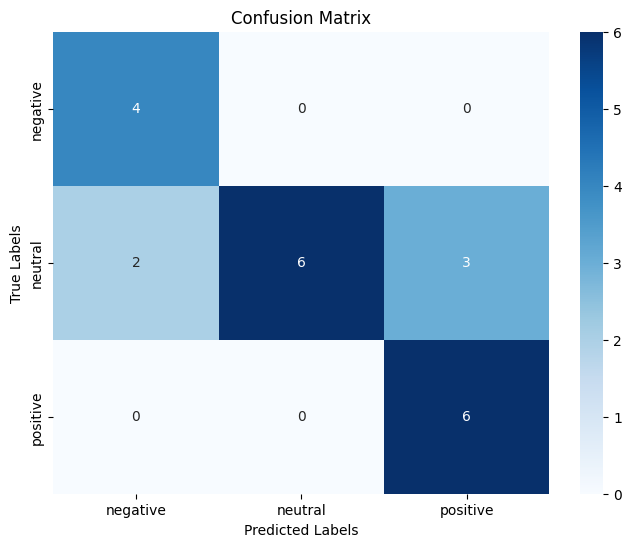

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Explainability

In [183]:
text_result_query[0]

'`` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .'

In [184]:
cleaned_text_result_query[0]

'marimekko operates industry change business climate reflect consumer demand'

In [185]:
len(text_result_query), len(cleaned_text_result_query), len(actual_labels), len(predicted_labels)

(21, 21, 21, 21)

In [186]:
query_results[queries[0]][0]['text']

'`` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .'

In [187]:
query_results[queries[0]]

[{'text': '`` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .',
  'sentiment': 'neutral',
  'cleaned_text': 'marimekko operates industry change business climate reflect consumer demand'},
 {'text': '`` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .',
  'sentiment': 'neutral',
  'cleaned_text': 'research show access information technology one limit factor small business especially work heterogenous network base environment'},
 {'text': "The Apple Inc. iPhone wo n't change the game plan for Verizon Communications Inc. , Chief Executive Ivan Seidenberg said Wednesday .",
  'sentiment': 'neutral',
  'cleaned_text': 'apple inc iphone wo n change game plan verizon communication inc chief executive ivan seidenberg say wednesday'}]

The heatmap visualizes the **attention weights** from a transformer model, showing how much attention each token in a text pays to every other token. Here's a breakdown:
- X-axis (horizontal): Represents the source tokens, which are giving attention.

- Y-axis (vertical): Represents the target tokens, which are receiving attention.

Each cell in the matrix, located at row $i$ and column $j$, indicates how much the token $i$ is attending to token $j$. Higher values (lighter colors) mean stronger attention, while lower values (darker colors) mean weaker attention.

The heatmap helps you understand which **tokens influence each other** the most during the model's processing, revealing relationships between words and showing how the model interprets the input text.

When tokenizing input text, the number of tokens you see in the tokenized output may differ from the number of tokens represented in the attention heatmap due to the following reasons:

-    **Padding Tokens**: The model often pads input sequences to a fixed length (e.g., to handle batches of varying lengths). These padding tokens, denoted as [PAD], do not contribute meaningfully to the model’s predictions but are still part of the input sequence and appear in the attention weight matrix. However, since they are not important for the task, they typically receive minimal attention.

- **Special Tokens**: Models like BERT-based transformers add special tokens to the tokenized input:
  - **[CLS] (classification token)** is added at the beginning for classification tasks.
  - **[SEP] (separator token)** is added at the end to separate sentences in tasks involving multiple sentences.

These tokens help the model perform specific tasks, but they may not directly contribute to the sentiment analysis and might not be as relevant in the attention weights, even though they appear in the tokenized input.

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentence: In Europe , the paper industry 's situation is paradoxical .
Tokens of sentence: ['[CLS]', 'europe', 'paper', 'industry', 'situation', 'paradox', '##ical', '[SEP]']
Prediction: neutral, Ground truth: negative


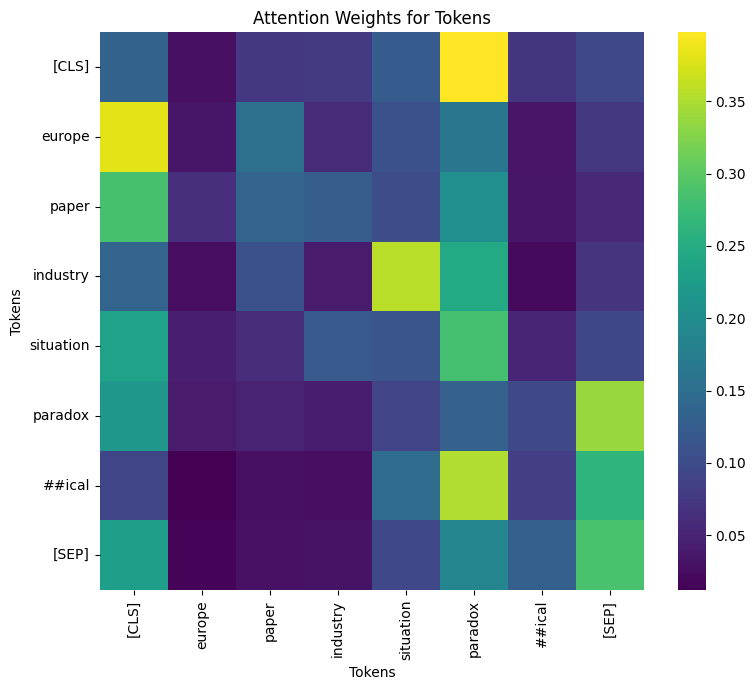

In [188]:
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

#index = 7
#index = 9
index = 10
#index = 15

model = AutoModel.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# tokenize queries
inputs = tokenizer(cleaned_text_result_query[index], return_tensors="pt", truncation=True)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(f"Sentence: {text_result_query[index]}")
print(f"Tokens of sentence: {tokens}")
print(f"Prediction: {actual_labels[index]}, Ground truth: {predicted_labels[index]}")

# get attention weights
outputs = model(**inputs)
attentions = outputs.attentions  # List of attention weights for each layer

# extract attention weights for the last layer and first attention head
last_layer_attention = attentions[-1][0][0].detach().numpy()  # Shape: [seq_len, seq_len]

# plot the heatmap with tokens as axis labels
plt.figure(figsize=(8, 7))
sns.heatmap(last_layer_attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis", cbar=True)
plt.title("Attention Weights for Tokens")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

This following piece of code analyzes the attention weights of a transformer model to identify which tokens in the input text are most relevant to the model's decision-making process. The model generates attention scores for each token, showing how much focus it gives to other tokens. These scores are averaged across attention heads and summed for each token to determine its relevance. The top tokens with the highest attention scores are printed and visualized in a bar plot, showing which parts of the text most influence the model's output.

The attention weights from the last layer are typically averaged across all attention heads to simplify the interpretation. Each attention head learns different aspects of the input, and averaging them provides a more generalized view of which tokens the model deems most important for its final decision. This averaged attention gives a clearer, less noisy understanding of the model's focus, helping to identify key tokens influencing the prediction.

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Top tokens by attention relevance:
Token: paper, Attention: 1.8362
Token: situation, Attention: 1.4886
Token: [SEP], Attention: 1.3008
Token: paradox, Attention: 1.2988
Token: [CLS], Attention: 0.8281
Token: ##ical, Attention: 0.5095
Token: industry, Attention: 0.4496
Token: europe, Attention: 0.2884


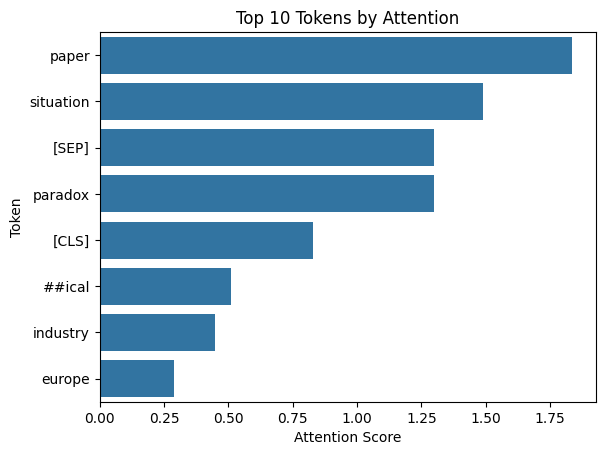

In [189]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

index = 10

# load model and tokenizer
model = AutoModel.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# tokenize query
inputs = tokenizer(cleaned_text_result_query[index], return_tensors="pt", truncation=True, return_offsets_mapping=True)
offset_mapping = inputs.pop("offset_mapping")  # Posizione di ciascun token rispetto al testo originale

# retrieve weights
outputs = model(**inputs)
attentions = outputs.attentions  # Lista dei pesi di attenzione per ogni layer

# take last layer and compute mean
last_layer_attention = attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
avg_attention = last_layer_attention.mean(dim=1)  # Media degli head: [batch_size, seq_len, seq_len]

# sum the attentions for each token
token_relevance = avg_attention[0].sum(dim=0).detach().numpy()  # [seq_len]

# decode tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# order tokens
token_with_relevance = list(zip(tokens, token_relevance))
sorted_tokens = sorted(token_with_relevance, key=lambda x: x[1], reverse=True)

print("Top tokens by attention relevance:")
for token, relevance in sorted_tokens[:10]:  # Primi 10 token
    print(f"Token: {token}, Attention: {relevance:.4f}")

# plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=[t[1] for t in sorted_tokens[:10]], y=[t[0] for t in sorted_tokens[:10]])
plt.title("Top 10 Tokens by Attention")
plt.xlabel("Attention Score")
plt.ylabel("Token")
plt.show()

In [190]:
import shap

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# initialize SHAP explainer
explainer = shap.Explainer(sentiment_classifier, tokenizer=tokenizer)

# generate shap values
shap_values = explainer([cleaned_text_result_query[index]])

print(f"Prediction: {actual_labels[index]}, Ground truth: {predicted_labels[index]}")

# visualize shap
shap.text_plot(shap_values)

Prediction: neutral, Ground truth: negative
